In [2]:
%run ../../base-notebook.ipynb

--2023-05-26 22:16:42--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘contents.txt’

contents.txt        100%[===================>]     666  --.-KB/s    in 0s      

2023-05-26 22:16:43 (79.4 MB/s) - ‘contents.txt’ saved [666/666]

--2023-05-26 22:16:43--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8151 (8.0K) [text/plain]
Saving to: ‘ml_callbac

In [3]:
import sys

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_plot as mlp
import ext.ml_util as mlu
import ext.ml_data as mld
import ext.ml_view as mlv
import ext.ml_analyze as mla

import tensorflow as tf

from keras import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, GlobalAveragePooling2D, Activation
from keras.losses import sparse_categorical_crossentropy

TensorFlow version: 2.12.0
Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Milestome Project 1: Food Vision Big

## Check GPU

Google Colab offers free GPU's, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 from within Google Colab, or if we are using our own hardware our GPU needs a score of 7.0+. See https://developer.nvidia.com/cuda-gpus

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-12c95e89-2cc3-713d-d9e0-d322f468902c)


## Get helper functions

In past modules we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from here.

The script we've got available can be found on github.

In this case we have the ml-utilities at the to of this notebook.

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview


In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101" in datasets_list) # Is our target dataset in the list of TFDS?

2023-05-26 22:17:50.735838: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


True


In [5]:
# Load in the data (takes 5-6 minues in Google Colab)
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Shuffling /Users/sodeso/tensorflow_datasets/food101/2.0.0.incompleteAHTNKC/food101-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /Users/sodeso/tensorflow_datasets/food101/2.0.0.incompleteAHTNKC/food101-validation.tfrecord*...:   …

Dataset food101 downloaded and prepared to /Users/sodeso/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1 Max


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or or are they label encoded)
* Do the labels match up with the class names?

In [6]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [95]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [20]:
# Take one sample of train data
train_one_sample = train_data.take(1) # Samples are in formate (image_tensor, label)

In [21]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [23]:
# What does our image tensor from TDFS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [24]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### PLot an image from TensorFlow Datasets

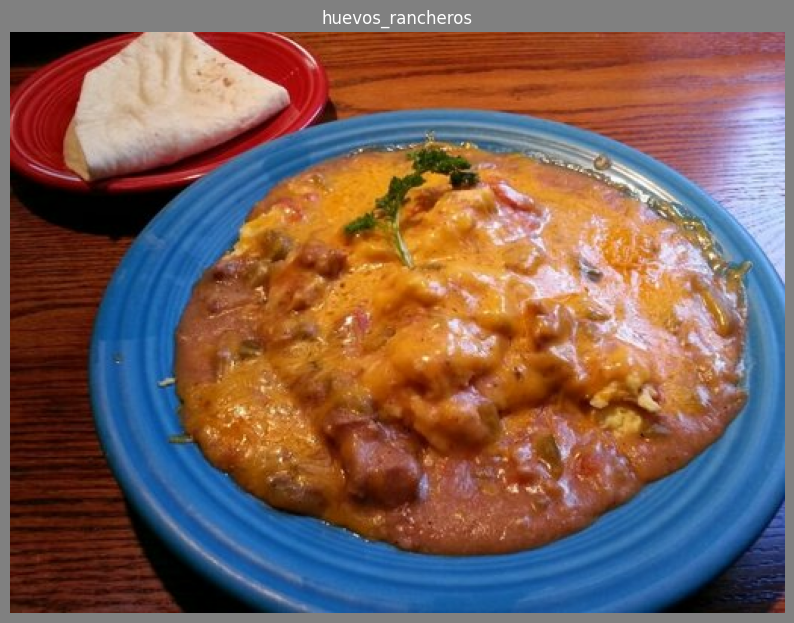

In [25]:
mlv.show_single_image_from_nparray_or_tensor(image=image, title=class_names[label.numpy()])

## Create preprocessing functions for our data

Neural netwroks perform best when data is in a certain way e.g. batched, normalized, etc.

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In 'uint8' datatype.
* Comprised of all different size tensors (different image sizes)
* Not scaled ( the pixel values are between 0 & 255)

What we know models like:
* Data in 'float32' dtype (or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling build-in).

This means our function needs to:
1. Reshape our images to all of the the same size
2. Convert the dtype of our image tensors from 'unint8' to 'float32'

In [7]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Coinverts image datatype from 'uint8' -> 'float32' and 
  reshapes image to [img_shape, img_shape, channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # Reshape target image
  # image = image/255. # Scale image values, not required with EfficientNetBX
  return tf.cast(image, tf.float32), label # Return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n{image[0][:10]}..., \nShape: {image.shape}, Datatype: {image.dtype}")
print(f"Image after preprocessing: \n{preprocessed_img[0][:10]}..., \nShape: {preprocessed_img.shape}, Datatype: {preprocessed_img.dtype}")

Image before preprocessing: 
[[189 165 121]
 [185 161 117]
 [181 157 113]
 [181 157 113]
 [182 159 117]
 [185 162 120]
 [185 162 120]
 [184 161 119]
 [182 159 118]
 [182 159 118]]..., 
Shape: (512, 512, 3), Datatype: <dtype: 'uint8'>
Image after preprocessing: 
[[184.91327  160.91327  116.91326 ]
 [180.35715  156.35715  112.35714 ]
 [183.71428  160.71428  118.71429 ]
 [183.       160.       118.5     ]
 [182.78061  160.56633  121.13776 ]
 [184.81122  162.81122  123.811226]
 [187.42857  165.42857  128.17348 ]
 [184.96938  162.96938  122.68367 ]
 [196.46939  174.46939  136.66327 ]
 [203.86224  181.50511  147.71939 ]]..., 
Shape: (224, 224, 3), Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly recommend ging through the following guide: http://tensorflow.org/guide/data_performance (Data input pipelines)

In [8]:
# Map preprocessing function to training (and parallizing)
train_data_pre = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch is (load it faster)
train_data_pre = train_data_pre \
  .shuffle(buffer_size=1000) \
  .batch(batch_size=32) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) # Size of buffer can be done on len(train_data) but does require a lot of memory.

# Map preprocessing function to the test data
test_data_pre = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batch_size=32) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

"Het, tensorFlow, map this preprocessing function (preprocess_img) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch,"

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TrensorBoard callback to log training results, so we can visualize then later.
* ModelCheckpoint callback to save our models progress after feature extraction

In [9]:
# Create tensorboard callback
tensorboard_callback = mlc.create_tensorboard_callback(
    experiment_name="EfficientV2B0_101_classes_all_data_feature_extract")

# Create ModelCheckpoint callback to save models progress during training
modelcheckpoint_callback = mlc.create_model_checkpoint_callback(
    experiment_name="EfficientV2B0_101_classes_all_data_feature_extract", 
    metric="val_loss", 
    save_weights_only=True, 
    save_best_only=True,
    verbose=0)

Saving TensorBoard log files to: ./logs/EfficientV2B0_101_classes_all_data_feature_extract/20230528-123911


## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [10]:
# Turn on mixed precision training
mlu.set_mixed_precision_policy_for_gpu()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [20]:
!nvidia-smi

Thu May 25 18:46:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Build feature extraction model

In [21]:
# Create base model
INPUT_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional modal
input_layer = Input(shape=INPUT_SHAPE, name="input_layer")
# x = Rescaling(scale=1/255.)(input_layer)
x = base_model(input_layer, training=False) # Make sure layers which should be in inference mode only stay like that
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
x = Dense(units=len(class_names), activation=None, name="output_dense_layer")(x)
output_layer = Activation(activation='softmax', dtype=tf.float32, name="output_activation_layer")(x)
model = Model(input_layer, output_layer)

model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 1s 0us/step


In [22]:
mll.list_model(model=model, recursive=False)

row   | name (type)                                        | dtype   | policy        | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | efficientnetv2-b0         (Functional            ) | float32 | mixed_float16 | False     | (None, None, None, 1280)
2     | global_average_pooling_2d (GlobalAveragePooling2D) | float32 | mixed_float16 | True      | (None, 1280)            
3     | output_dense_layer        (Dense                 ) | float32 | mixed_float16 | True      | (None, 101)             
4     | output_activation_layer   (Activation            ) | float32 | float32       | True      | (None, 101)             


Going through the above we can see that the layers efficientnetv2-b0, global_average_pooling_2d and output_dense_layer are storing their values in float32 but compute using mixed_float16.

In [23]:
mlu.get_mixed_precision_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [24]:
# Fit the feature extraction model

history_101_food_classes_feature_extract = model.fit(train_data_pre,
                    steps_per_epoch=len(train_data_pre),
                    validation_data=test_data_pre,
                    validation_steps=int(0.15 * len(test_data_pre)),
                    epochs=3,
                    callbacks=[tensorboard_callback, modelcheckpoint_callback])

Epoch 1/3
2368/2368 [==============================] - 210s 81ms/step - loss: 1.7509 - accuracy: 0.5771 - val_loss: 1.1402 - val_accuracy: 0.6986
Epoch 2/3
2368/2368 [==============================] - 187s 77ms/step - loss: 1.2120 - accuracy: 0.6874 - val_loss: 1.0386 - val_accuracy: 0.7214
Epoch 3/3
2368/2368 [==============================] - 188s 78ms/step - loss: 1.0651 - accuracy: 0.7219 - val_loss: 0.9870 - val_accuracy: 0.7352


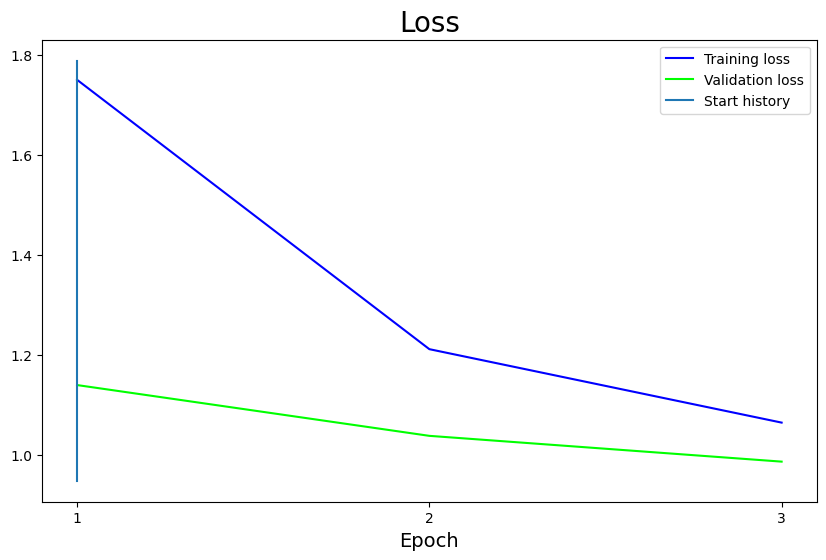

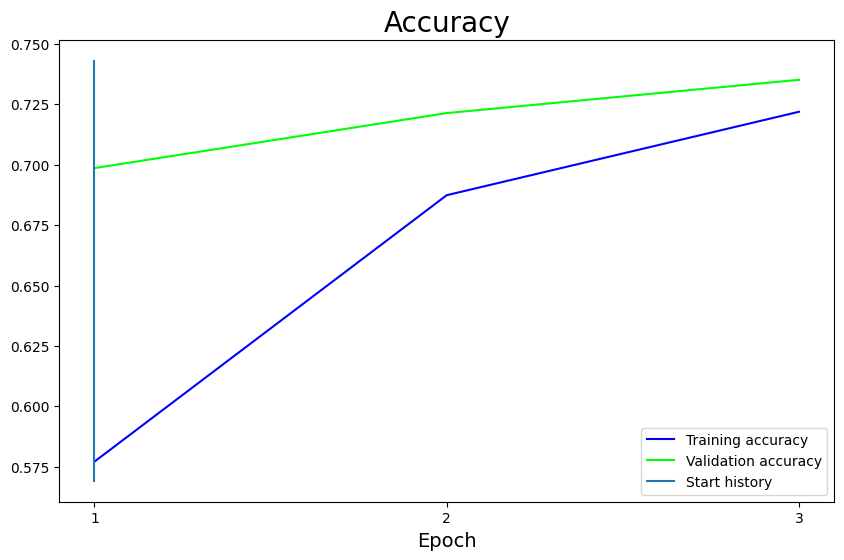

In [25]:
mlp.plot_history(history_101_food_classes_feature_extract)

In [26]:
results_feature_extraction_model = model.evaluate(test_data_pre)
results_feature_extraction_model

790/790 [==============================] - 57s 72ms/step - loss: 0.9932 - accuracy: 0.7307


[0.993161141872406, 0.7306930422782898]

## Off you go

We've covered a lot of ground so fat but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

## TODO: Save the whole model to file

In [27]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
mll.save_model_alt(model=model, directory="./saved_models", name="model")

In [28]:
# Load model previously saved above
loaded_model = mll.load_model_alt(directory="./saved_models", name="model")

In [29]:
# Check the layers in the base model and see what dtype policy they're using
mll.list_model(model=loaded_model)

row   | name (type)                                         | dtype   | policy        | trainable | output shape
0     | input_layer                (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | input_1                    (InputLayer            ) | float32 | float32       | True      | [(None, None, None, 3)] 
2     | rescaling                  (Rescaling             ) | float32 | mixed_float16 | False     | (None, None, None, 3)   
3     | normalization              (Normalization         ) | float32 | mixed_float16 | False     | (None, None, None, 3)   
4     | stem_conv                  (Conv2D                ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
5     | stem_bn                    (BatchNormalization    ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
6     | stem_activation            (Activation            ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
7     | bloc

In [30]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
loaded_model.compile(loss=sparse_categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

loaded_model_evaluation_result = loaded_model.evaluate(test_data_pre)
loaded_model_evaluation_result

790/790 [==============================] - 68s 81ms/step - loss: 0.9932 - accuracy: 0.7307


[0.9931613802909851, 0.7306930422782898]

In [32]:
import numpy as np

# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
print(f"Close? {np.isclose(loaded_model_evaluation_result[1], results_feature_extraction_model[1])} | Difference: {loaded_model_evaluation_result[1] - results_feature_extraction_model[1]}")


Close? True | Difference: 0.0


## TODO: Preparing our model's layers for fine-tuning

Next: Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [21]:
# Download the saved model from Google Storage
mli.download_file(source="https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip ", 
                  destination="07_efficientnetb0_feature_extract_model_mixed_precision.zip")

In [22]:
# Unzip the SavedModel downloaded from Google Storage
mli.extract_zip(file="07_efficientnetb0_feature_extract_model_mixed_precision.zip")

In [25]:
# Load and evaluate downloaded GS model
loaded_model_2 = tf.keras.models.load_model(filepath="/content/07_efficientnetb0_feature_extract_model_mixed_precision")

In [26]:
# Get a summary of the downloaded model
loaded_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [27]:
# How does the loaded model perform? (evaluate it on the test dataset)
loaded_model_2_evaluation_result = loaded_model_2.evaluate(test_data_pre)
loaded_model_2_evaluation_result

790/790 [==============================] - 69s 75ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880993604660034, 0.7066138386726379]

In [28]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
loaded_model_2.trainable = True

In [29]:
# Check to see what dtype_policy of the layers in your loaded model are
mll.list_model(loaded_model_2)

row   | name (type)                                        | dtype   | policy        | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | input_1                   (InputLayer            ) | float32 | float32       | True      | [(None, None, None, 3)] 
2     | rescaling                 (Rescaling             ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
3     | normalization             (Normalization         ) | float32 | float32       | True      | (None, None, None, 3)   
4     | stem_conv_pad             (ZeroPadding2D         ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
5     | stem_conv                 (Conv2D                ) | float32 | mixed_float16 | True      | (None, None, None, 32)  
6     | stem_bn                   (BatchNormalization    ) | float32 | mixed_float16 | True      | (None, None, None, 32)  
7     | stem_activat

In [30]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping_callback = mlc.create_early_stopping_callback(patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
model_checkpoint_callback = mlc.create_model_checkpoint_callback(experiment_name="loaded_model_2", save_best_only=True, save_weights_only=True)

# Create a Tensorbaord callback
tensorboard_callback = mlc.create_tensorboard_callback(experiment_name="loaded_model_2")

# Create a reduce learning rate on plateau callback
reduce_lr_on_plateau_callback = mlc.create_reduce_lr_on_plateau_callback()

Saving TensorBoard log files to: ./logs/loaded_model_2/20230525-184900


In [31]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
loaded_model_2.compile(loss=sparse_categorical_crossentropy,
                     optimizer=Adam(learning_rate=0.001 * 0.1),
                     metrics=["accuracy"])

In [32]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_loaded_model_2 = loaded_model_2.fit(train_data_pre,
                                            steps_per_epoch=len(train_data_pre),
                                            validation_data=test_data_pre,
                                            validation_steps=len(test_data_pre),
                                            epochs=100,
                                            callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback, reduce_lr_on_plateau_callback])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.7512
Epoch 1: val_loss improved from inf to 0.79102, saving model to ./checkpoints/loaded_model_2/model-epoch-01-val_loss-0.79.hdf5
2368/2368 [==============================] - 425s 171ms/step - loss: 0.9232 - accuracy: 0.7512 - val_loss: 0.7910 - val_accuracy: 0.7817 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.8403
Epoch 2: val_loss improved from 0.79102 to 0.78673, saving model to ./checkpoints/loaded_model_2/model-epoch-02-val_loss-0.79.hdf5
2368/2368 [==============================] - 405s 169ms/step - loss: 0.5806 - accuracy: 0.8403 - val_loss: 0.7867 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.9064
Epoch 3: val_loss did not improve from 0.78673
2368/2368 [==============================] - 407s 170ms/step - loss: 0.3295 - accuracy: 0.

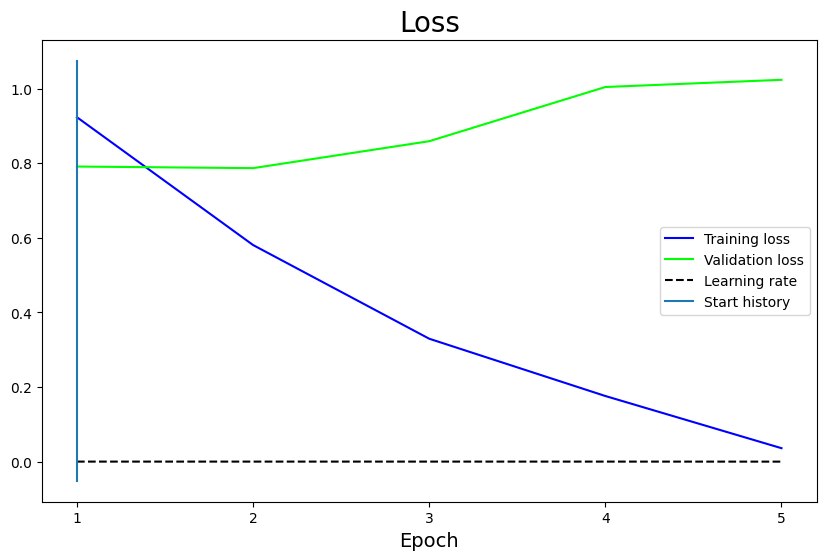

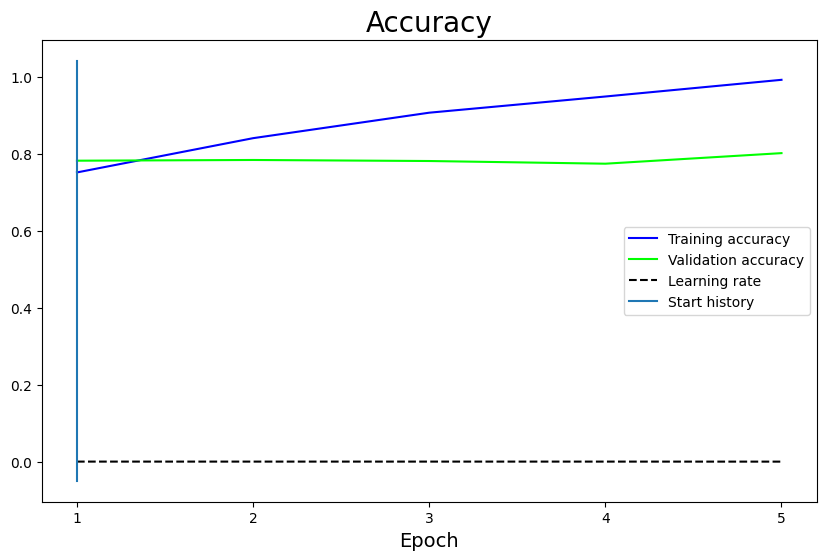

In [34]:
mlp.plot_history(history=history_loaded_model_2)

In [50]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
mll.save_model_alt(model=loaded_model_2, directory="./saved_models", name="loaded_model_2")

In [33]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
loaded_model_2_evaluation = loaded_model_2.evaluate(test_data_pre)
loaded_model_2_evaluation

790/790 [==============================] - 56s 70ms/step - loss: 0.7867 - accuracy: 0.7836


[0.7867292165756226, 0.7836039662361145]

In [54]:
# !tar -zcvf loaded_model_2_model.tar.gz ./saved_models
# !tar -zcvf loaded_model_2_tensorbaord.tar.gz ./logs/loaded_model_2

./logs/loaded_model_2/
./logs/loaded_model_2/20230525-122756/
./logs/loaded_model_2/20230525-122756/train/
./logs/loaded_model_2/20230525-122756/train/events.out.tfevents.1685017774.ea4a23ac9444.256.2.v2
./logs/loaded_model_2/20230525-122756/validation/
./logs/loaded_model_2/20230525-122756/validation/events.out.tfevents.1685018139.ea4a23ac9444.256.3.v2


## TODO: View training results on TensorBoard

To do: Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [72]:
# Download and evaluate fine-tuned model from Google Storage
mli.download_file(source="https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip", destination="07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip")
mli.extract_zip("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip")

In [73]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [74]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data_pre)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 66s 72ms/step - loss: 0.9072 - accuracy: 0.8015


[0.9072170257568359, 0.8014653325080872]

TODO: Evaluate your trained model

Some ideas you might want to go through:

Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).
See the evaluation section at the end of Transfer Learning Part 3: Scaling Up for more: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

In [ ]:
# Load the model again in case the colab environment has been restarted.
# loaded_model_2 = mll.load_model_alt(directory="/content/saved_models", name="loaded_model_2", format="h5")
# loaded_model_2.compile(loss=sparse_categorical_crossentropy,
#                        optimizer=Adam(0.001 * 0.1),
#                        metrics=["accuracy"])

In [110]:
preds = loaded_fine_tuned_gs_model.predict(test_data_pre)
preds

790/790 [==============================] - 61s 76ms/step


array([[8.7890698e-04, 1.1010805e-11, 2.4151148e-09, ..., 8.3338591e-07,
        2.1313313e-09, 3.4222517e-03],
       [8.6585744e-10, 4.2021460e-12, 2.8552949e-10, ..., 2.5888666e-12,
        3.3785359e-08, 1.1134577e-12],
       [3.2038157e-11, 1.8542265e-11, 9.5246933e-13, ..., 5.6874546e-13,
        2.2944829e-10, 9.5246933e-13],
       ...,
       [1.9762805e-04, 9.5912071e-07, 2.3342542e-14, ..., 1.1586634e-09,
        4.3230961e-07, 9.7832977e-05],
       [1.3586667e-14, 6.0001650e-21, 7.5417320e-20, ..., 2.1183172e-22,
        1.0105927e-21, 8.0160564e-17],
       [9.0048752e-06, 2.1882594e-10, 2.9570328e-08, ..., 2.0730399e-06,
        3.2223916e-08, 3.6878316e-07]], dtype=float32)

In [112]:
# labels_pre = get_labels_from_dataset(train_data_pre)
labels = mld.get_labels_from_dataset(test_data_pre)

In [146]:
# Calculate accuracy
sklearn_accuracy = mla.calculate_accuracy(labels, preds)
sklearn_accuracy

0.8014653465346535

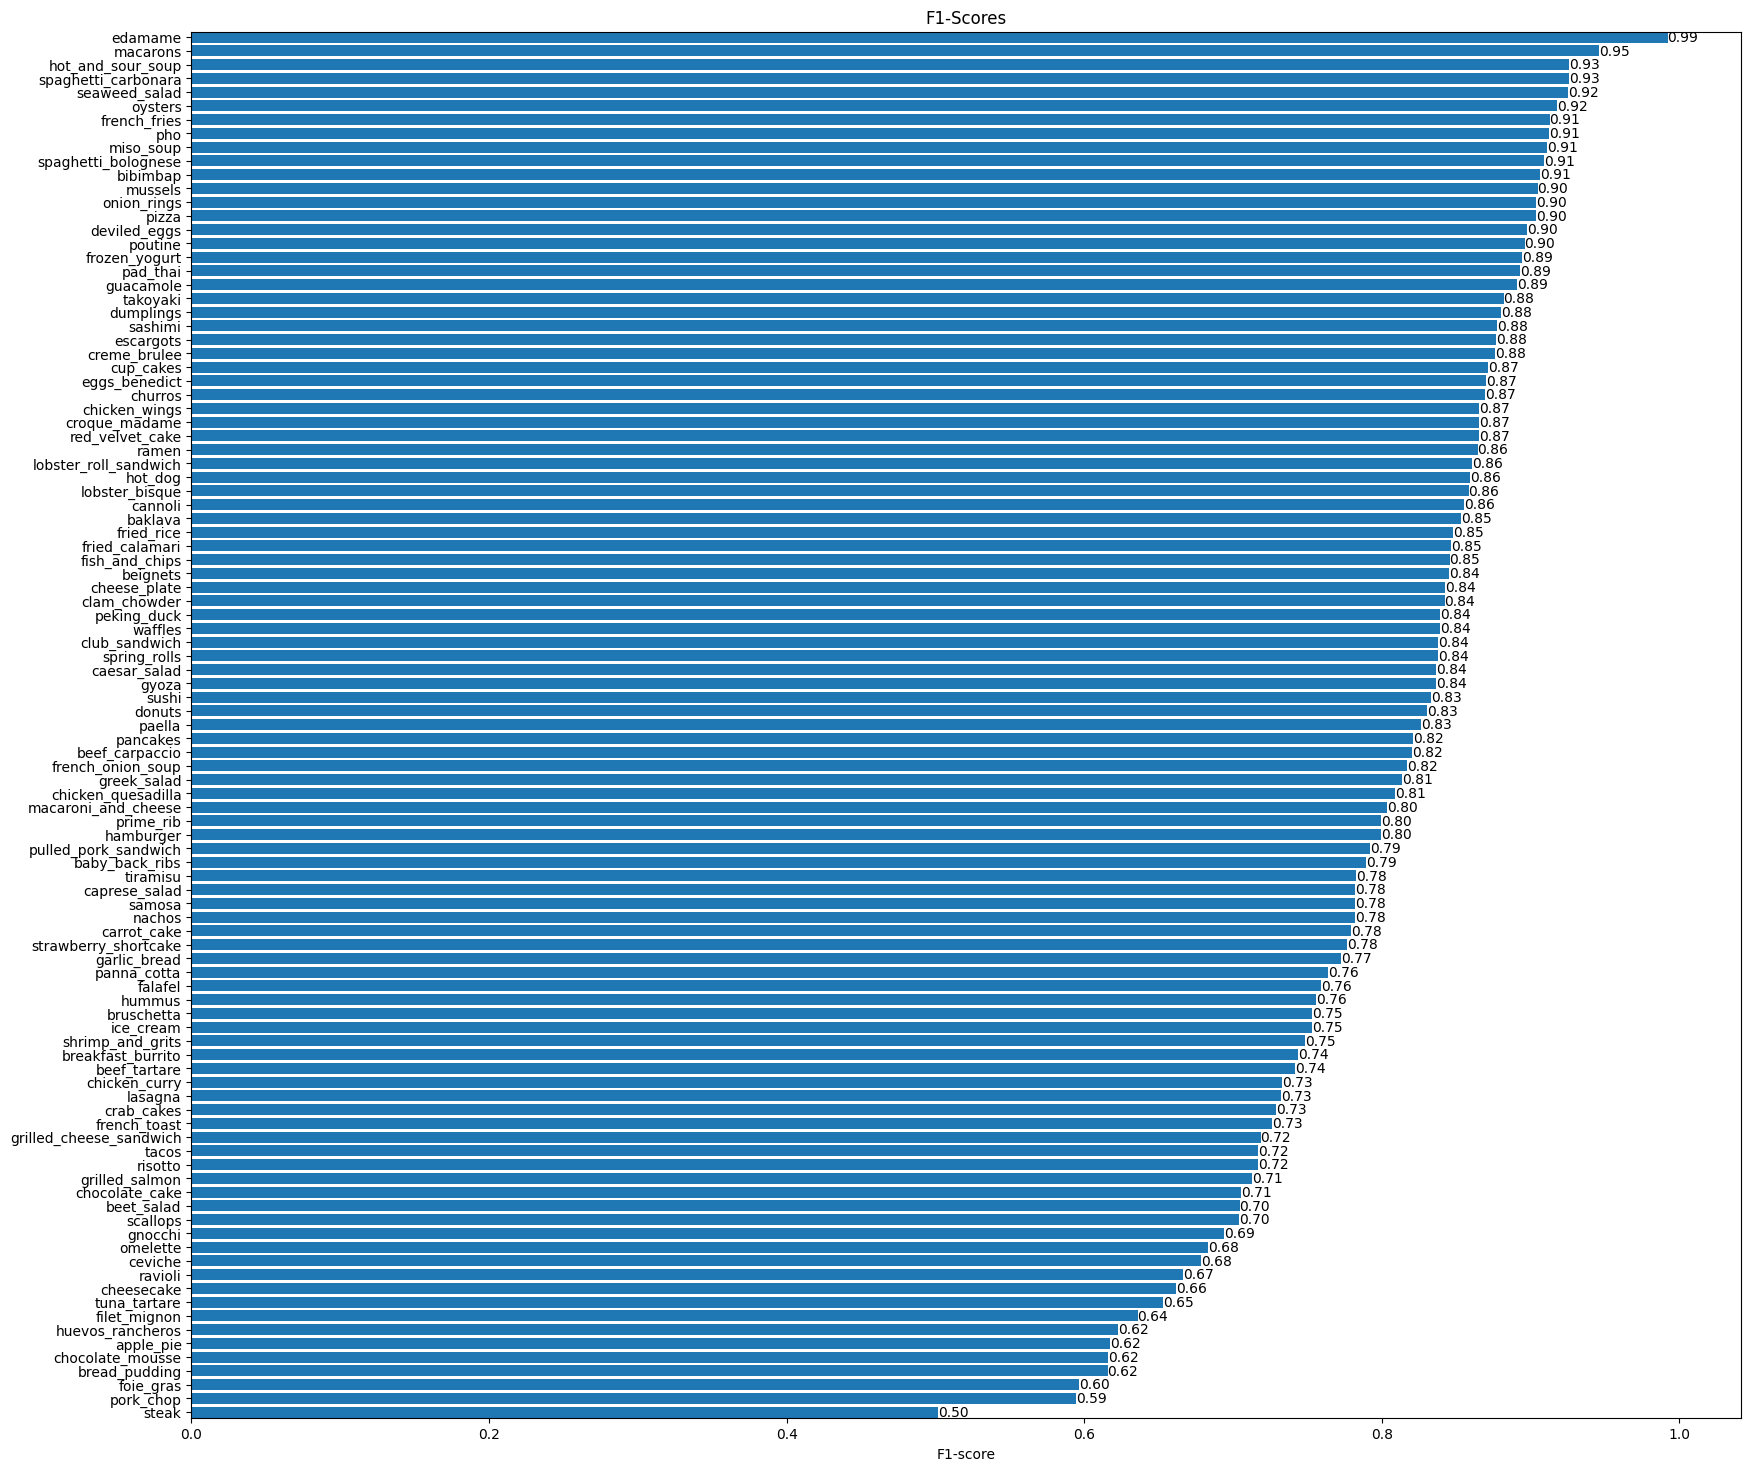

In [119]:
mlp.plot_classification_report_f1_score(y_true=labels, y_pred=preds, class_names=class_names, figsize=(20, 18))

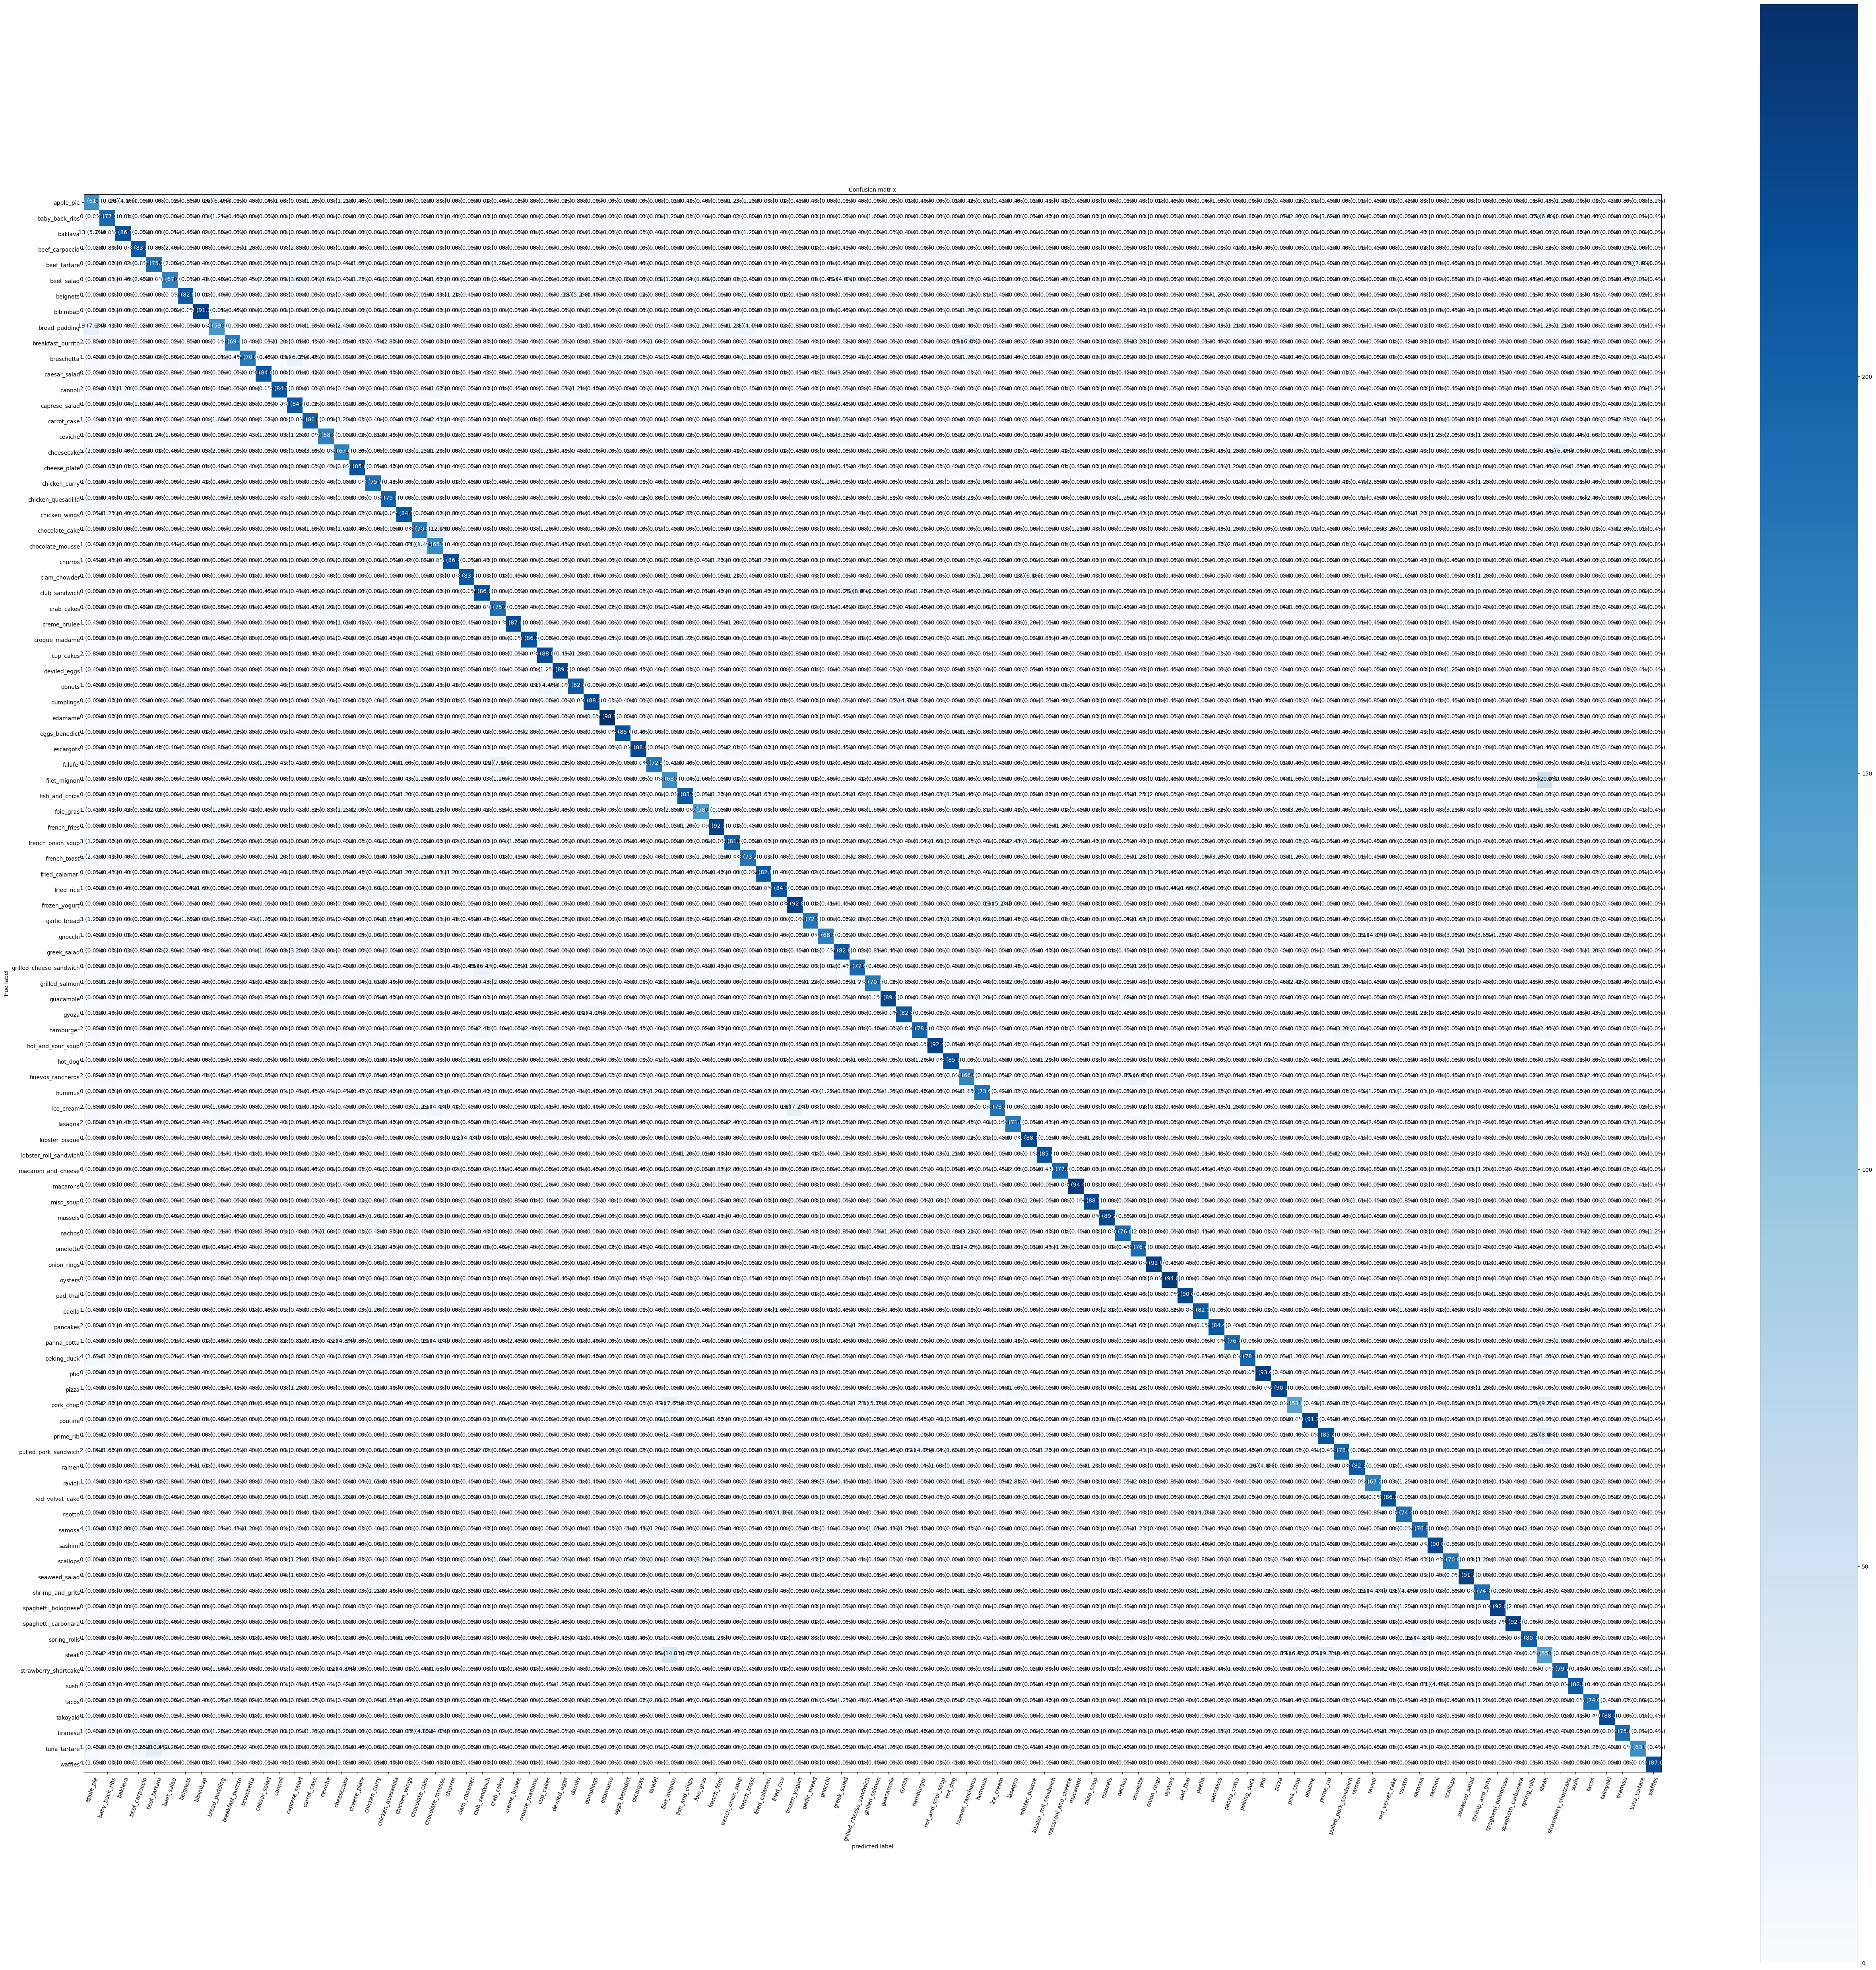

In [127]:
mlp.plot_confusion_matrix(y_true=labels, y_pred=preds, class_names=class_names, figsize=(64, 64), norm=True, savefig=True)

Exercises

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
* A confusion matrix between all of the model's predictions and true labels.
* A graph showing the f1-scores of each class.
* A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

## Extra-curriculum

* Read up on learning rate scheduling and the learning rate scheduler callback. What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders (improving TensorFlow data loading performance: https://www.tensorflow.org/guide/data_performance). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* ead up on the documentation for TensorFlow mixed precision training: https://www.tensorflow.org/guide/mixed_precision. What are the important things to keep in mind when using mixed precision training?